<a href="https://colab.research.google.com/github/Prem-Swarup/Facial-Expression-Recognition/blob/main/Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition
- Implemented using pytorch framework
- CNN is used for classification
- Used to decrease the training time per epoch from around 10 mins to under mins
- Gained approx. 65% accuracy on test set 


## Dataset available at kaggle 

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

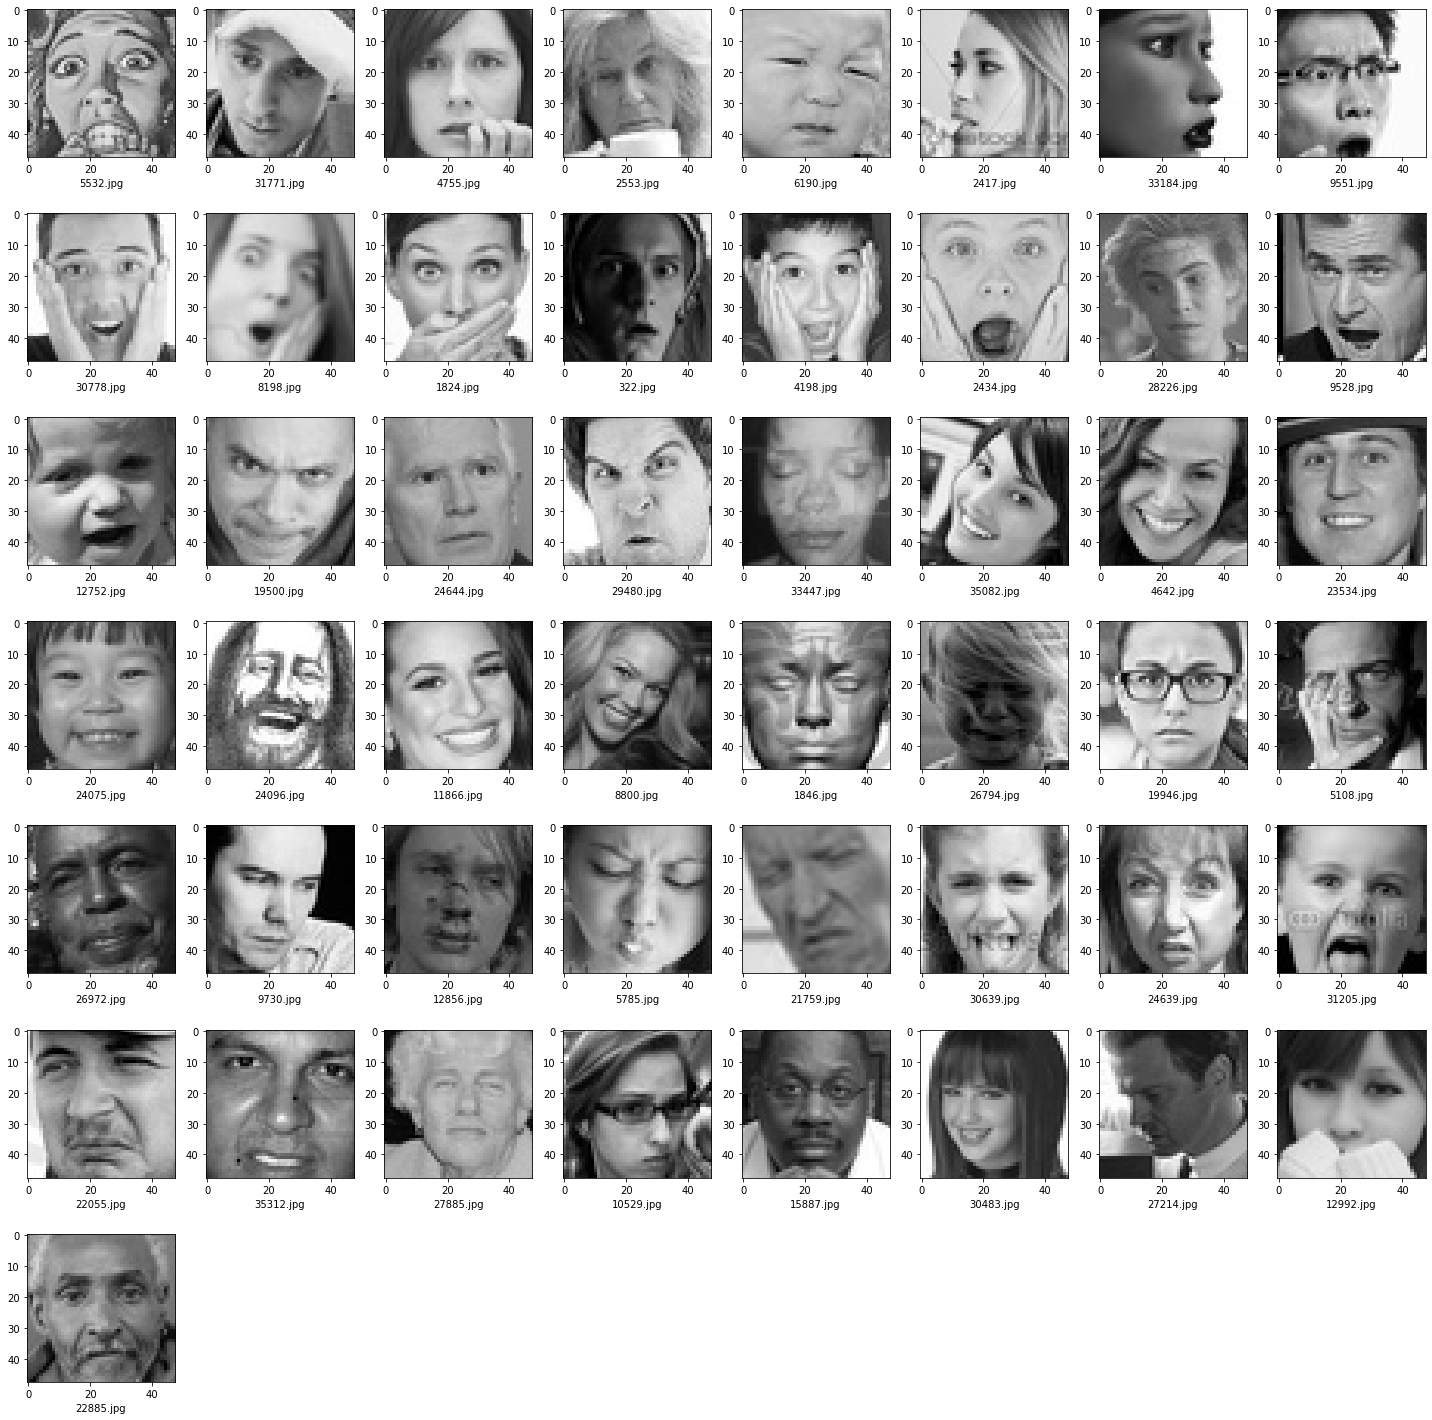

# Install libraries, packages and dataset

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git ;
!pip install -U git+https://github.com/albumentations-team/albumentations ;
!pip install timm ;
!pip install --upgrade opencv-contrib-python ;

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-h2u375gh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-h2u375gh
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

# Configurations

In [3]:
train_img_path = '/content/Facial-Expression-Dataset/train/'
valid_img_path = '/content/Facial-Expression-Dataset/validation'
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset 

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T 

In [5]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [6]:
trainset_ = ImageFolder(train_img_path, transform=train_augs)
validset = ImageFolder(valid_img_path, transform=valid_augs)

train_size = int(0.85 * len(trainset_))
test_size = len(trainset_) - train_size
trainset, testset = torch.utils.data.random_split(trainset_, [train_size, test_size])

In [7]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")
print(f"Total no. of examples in trainset : {len(testset)}")

Total no. of examples in trainset : 24497
Total no. of examples in validset : 7066
Total no. of examples in trainset : 4324


In [9]:
print(trainset_.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '2')

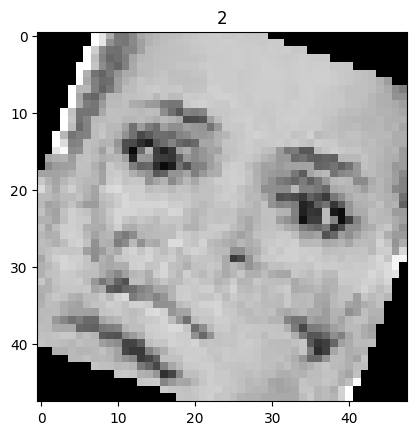

In [10]:
image, label = trainset[30]
plt.imshow(image.permute(1, 2, 0)) # changed orientation to (h, w, c)
plt.title(label)

# Load Dataset into Batches 

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)


In [13]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 766
Total no. of batches in validloader : 221


In [14]:
for images, labels in trainloader :
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model 

In [15]:
import timm 
from torch import nn 

In [16]:
class FaceModel(nn.Module) :
  def __init__(self) :
    super(FaceModel, self).__init__()
    self.eff_net = timm.create_model(MODEL_NAME, pretrained=True, num_classes=7)
    
  def forward(self, images, labels=None) :
    logits = self.eff_net(images)
    if labels is not None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss
    return logits


In [17]:
model = FaceModel()
model.to(DEVICE) ;

# Create Train and Eval Function 

In [18]:
from tqdm import tqdm 

In [19]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model, dataloader, optimizer, current_epo) :
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo+1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk) :
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)), 'acc' : '%6f' %float(total_acc/(t+1))})

  return total_loss/len(dataloader), total_acc/len(dataloader)


In [28]:
def eval_fn(model, dataloader, current_epo) :
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo+1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk) :
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    
    tk.set_postfix({'loss' : '%.6f' %float(total_loss/(t+1)), 'acc' : '%.6f' %float(total_acc/(t+1))})

  return total_loss/len(dataloader), total_acc/len(dataloader)


In [33]:
def test_fn(model, dataloader) :
  model.eval() 
  total_loss = 0.0
  total_acc = 0.0
  
  for images, labels in dataloader :
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
  
  return total_loss/len(dataloader), total_acc/len(dataloader)

# Create Training Loop

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [34]:
best_valid_loss = np.Inf 
accuracy = 0

for i in range(EPOCHS) :
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)
  
  if valid_loss < best_valid_loss :
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")


EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:07<00:00, 28.94it/s, loss=1.075393, acc=0.600983]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 33.51it/s, loss=1.047734, acc=0.602539]


SAVED-BEST-WEIGHTS


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:06<00:00, 33.78it/s, loss=1.031336, acc=0.618158]


SAVED-BEST-WEIGHTS


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 31.62it/s, loss=1.014905, acc=0.633821]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:07<00:00, 29.98it/s, loss=1.014610, acc=0.630558]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:07<00:00, 29.60it/s, loss=1.055811, acc=0.639053]


In [38]:
test_loss, test_accuracy = test_fn(model, testloader)
print("Loss on test set so obtained: {:.4f}".format(test_loss))
print("Accuracy on test set: {:.2f}%".format(test_accuracy.numpy()*100))

Loss on test set so obtained: 1.1265
Accuracy on test set: 60.16%


# Inference

In [36]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')

    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

Above are examples of images with probability of belonging to different classes:


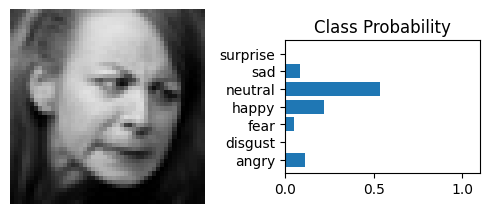

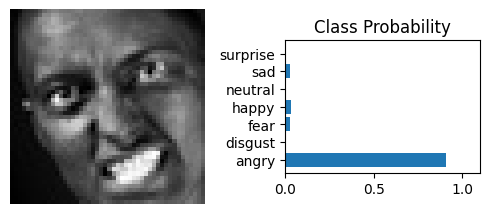

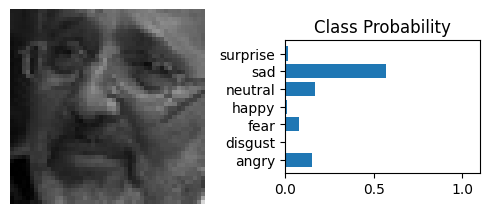

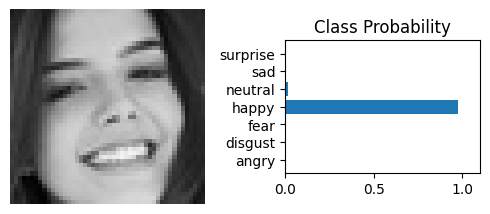

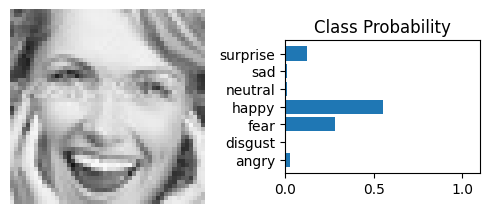

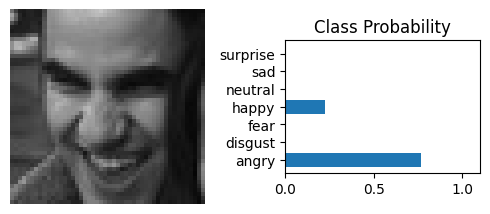

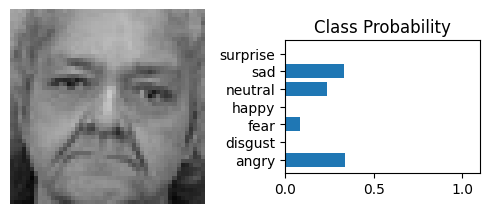

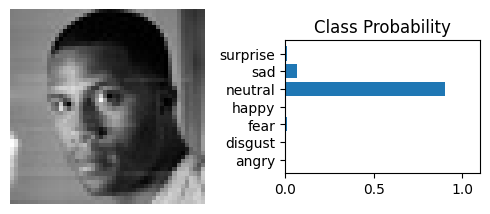

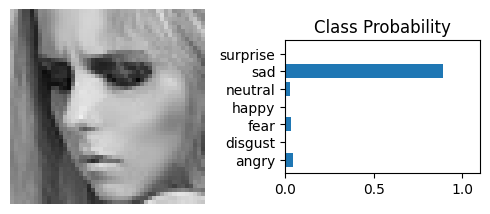

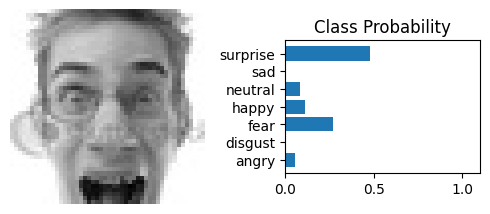

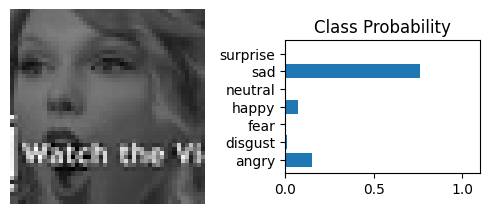

In [37]:
len_validset = len(validset)

for i in range(0, len_validset, len_validset//10) :
  image, label = validset[i]
  image = image.unsqueeze(0)
  logits = model(image.to(DEVICE))
  probs = nn.Softmax(dim = 1)(logits)
  view_classify(image.squeeze(), probs)

print("Below are examples of images with probability of belonging to different classes:")